In [1]:
import os
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imwrite
import time
import tensorflow as tf

In [3]:
def load_data():
    print('Loading data... ',end="",flush=True)
    dataset = './dataset'
    folderList = os.listdir(dataset)
    n_imgs = len(folderList)
    x_train = np.zeros((n_imgs,256,256,3))
    for i, fileName in enumerate(folderList):
        image = imread(os.path.join(dataset, fileName))
        image = tf.image.resize(image, (256,256)) 
        x_train[i,:] = (image - 127.5)/127.5   #Dejamos la imagen en un rango de (-1,1)
    print('Success')
    print(n_imgs)
    return x_train

Loading data... Success
3754
57
(3754, 256, 256, 3)


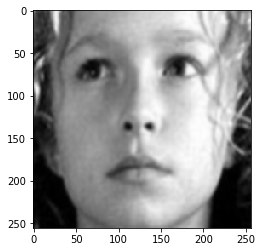

In [4]:
init = int(round(time.time()))
data = load_data()
final = int(round(time.time()))
print(final - init)
print(data.shape)

idx = np.random.randint(0,data.shape[0])
plt.imshow((data[idx] * 127.5 + 127.5)/255 )

In [2]:
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import Dense, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose, Reshape, Flatten, GaussianNoise
from tensorflow.python.keras.layers.core import Activation, Dropout
from tensorflow.keras.optimizers import Adam
OPTIMIZER = Adam(lr=1.5e-4, beta_1=0.5)

### Generador

Se ingresa un vector de 100 elementos y la primera capa tiene 1024x8x8 neuronas que luego con el reshape se convierten en 1024 "imágenes" de 8x8.

El batchNormalization nos ayuda a una convergencia más rápida al normalizar los valores

In [3]:
def create_generator():

    model = Sequential()
    model.add(Dense(1024*8*8, input_shape=(100,)))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,1024)))
    #8x8x1024

    model.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.2))
    #16x16x512

    model.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.2))
    #32x32x256

    model.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.2))
    #64x64x128

    model.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.2))
    #128x128x64

    model.add(Conv2DTranspose(3, (5,5),strides=(2,2),padding='same'))
    model.add(Activation('tanh'))
    #256x256x3

    model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy')

    return model


### Discriminador
El discriminador es una red convolucional para determinar si la imagen que llega es real o falsa.

GaussianNoise y Dropout son usados para evitar un overfitting 

In [4]:
def create_discriminator():
    
    model = Sequential()

    #add Gaussian noise to prevent Discriminator overfitting
    model.add(GaussianNoise(0.1, input_shape = [256, 256, 3]))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    #128x128x64

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    #64x64x128

    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    #64x64x256

    model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    #16x16x512

    model.add(Conv2D(1024, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    #8x8x1024

    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy')

    return model


In [5]:
def create_GAN(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy')

    return model

In [9]:
def save_img(generator, vector, name):
    fake_imgs = generator.predict(vector)
    fake_imgs = fake_imgs[0]
    fake_imgs = fake_imgs.reshape(256,256,3)
    fake_imgs = (fake_imgs* 127.5 + 127.5)
    imwrite(os.path.join('./faces',name), fake_imgs.astype('float32'))

In [10]:
generator = create_generator()
discriminator = create_discriminator()
gan = create_GAN(generator, discriminator)

gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       24298883  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 17488001  
Total params: 41,786,884
Trainable params: 24,165,891
Non-trainable params: 17,620,993
_________________________________________________________________


In [11]:
def train_GAN(discriminator, generator, gan, data, batch_size=64,input_size=100,epochs=5000,last_epoch=0):
    path = './Models/partial'
    dLoss = []
    dAcc = []
    gLoss = []
    np.random.seed(15)
    sample_vector = np.random.normal(0,1, [1,100])
    np.random.seed(None)
    init = int(round(time.time()))
    for i in range(last_epoch + 1, last_epoch + epochs+1):
        if i % 10 == 0:
          print('Epoch ',i)


        # creamos imágenes un lote de falsas a partir de vectores de 100 números aleatorios
        vectors = np.random.uniform(-1.0, 1.0, size = [batch_size, input_size])
        fake_imgs = generator.predict(vectors)

        # tomamos de manera aleatoria imágenes reales

        idx = np.random.randint(low=0,high=data.shape[0],size = batch_size)
        real_imgs = data[idx]

        # entrenamos el discriminador
        discriminator.trainable = True

        #Estos números no son exactamente 1 o 0 para evitar el overfitting
        onesVector = np.random.uniform(0.99, 1.0, size = [batch_size])
        zerosVector = np.random.uniform(0, 0.01, size = [batch_size])

        X = np.concatenate((real_imgs,fake_imgs))
        Y = np.concatenate((onesVector,zerosVector))

        dError = discriminator.train_on_batch(X, Y)

        discriminator.trainable = False


        # para entrenar el generador entrenamos la GAN entera pero con el discriminador sólo 
        # haciendo predicciones y sin entrenarse
        vectors = np.random.uniform(-1.0, 1.0, size = [batch_size, input_size])

        gError = gan.train_on_batch(vectors, onesVector)


        dLoss.append(dError) 
        gLoss.append(gError)

        if i>=50 and (i % 50 == 0 or i == n_it):
            final = int(round(time.time()))
            
            generator.save_weights(path + 'generator/weights.hdf5')
            discriminator.save_weights(path + 'discriminator/weights.hdf5')
            save_img(generator, sample, str(i)+'_epoch.png')

            clear_output(wait=True)
            print('Epoch ' + str(i) + ': ' + str(final - init) + ' seconds')
            plt.plot(range(last_it, last_it + len(dLoss)), dLoss)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Discriminator Error')
            plt.show()
            print(dError)

            plt.plot(range(last_it, last_it + len(gLoss)), gLoss, label='Fake')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')        
            plt.title('Generator')
            plt.show()
            print(gError)

            sample = generator.predict(sample_vector)
            print(discriminator.predict(sample))

            idx = np.random.randint(low=0,high=data.shape[0],size = 1)
            real_imgs = data[idx]
            print(discriminator.predict(real_imgs))
    return discriminator, generator, gan

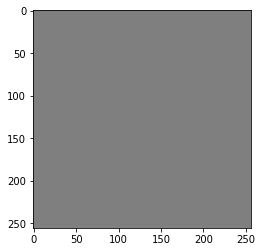

In [12]:
batch_size = 64
input_size = 100
n_it = 5000
last_it = 0

discriminator, generator, gan = train_GAN(discriminator, generator, gan, data, epochs=0)
sample_vector = np.random.normal(0,1, [1,100])
image = generator.predict(sample_vector.reshape(1,100))
plt.imshow((image.reshape(256,256,3) * 127.5 + 127.5)/255 )

In [7]:
path = './Models/stable/'
generator = create_generator()
discriminator = create_discriminator()
#generator = load_model(path + 'generator/model.hi5')
generator.load_weights(path + 'generator/weights.hdf5')
#discriminator = load_model(path + 'discriminator/model.hi5')
discriminator.load_weights(path + 'discriminator/weights.hdf5')
gan = create_GAN(generator, discriminator)

gan.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256, 256, 3)       24298883  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 17488001  
Total params: 41,786,884
Trainable params: 24,165,891
Non-trainable params: 17,620,993
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


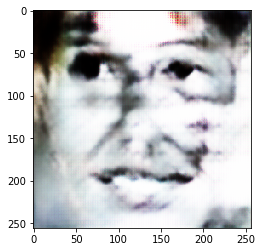

In [14]:
sample_vector = np.random.normal(0,1, [1,100])
image = generator.predict(sample_vector.reshape(1,100))
plt.imshow((image.reshape(256,256,3) * 127.5 + 127.5)/255 )